## DRACH Motifs

The middle 5-mers of the sequence will always be one of the 18 DRACH motifs.

In [51]:
# Define the possible nucleotides for each position
D = ['A', 'G', 'T']
R = ['A', 'G']
A = ['A']
C = ['C']
H = ['A', 'C', 'T']

# Initialize an empty list to store the DRACH motifs
drach_motifs = []

# Generate all combinations using nested loops
for d in D:
    for r in R: 
        for a in A:
            for c in C:
                for h in H:
                    motif = d + r + a + c + h
                    drach_motifs.append(motif)

# Print the list of DRACH motifs
print(drach_motifs)

['AAACA', 'AAACC', 'AAACT', 'AGACA', 'AGACC', 'AGACT', 'GAACA', 'GAACC', 'GAACT', 'GGACA', 'GGACC', 'GGACT', 'TAACA', 'TAACC', 'TAACT', 'TGACA', 'TGACC', 'TGACT']


## Loading The Data

In [52]:
import gzip
import json
import pandas as pd

### `dataset0.json.gz`

In [53]:
# Function to load data.json.gz file as dataframe
def load_json_gz_to_dataframe(file_path):
    data = []
    with gzip.open(file_path) as f:
        for line in f.readlines():
            json_data = json.loads(line)
            for transcript, positions in json_data.items():
                for position, sequences in positions.items():
                    position = int(position)
                    for sequence, reads in sequences.items():
                        data.append({
                            'transcript_id': transcript,
                            'position': position,
                            'sequence': sequence,
                            "data": reads
                            })
    return pd.DataFrame(data)

In [54]:
# Change the file path to the location of your dataset
file_path = 'dataset0.json.gz'
dataset = load_json_gz_to_dataframe(file_path)
dataset.head(3)

,transcript_id,position,sequence,data
0,ENST00000000233,244,AAGACCA,"[[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0..."
1,ENST00000000233,261,CAAACTG,"[[0.0126, 1.95, 111.0, 0.0125, 1.27, 108.0, 0...."
2,ENST00000000233,316,GAAACAG,"[[0.00432, 2.02, 104.0, 0.00299, 3.56, 99.3, 0..."


### `data.info.labelled`

In [55]:
# Change the file path to the location of your labels
file_path = 'data.info.labelled'
labels = pd.read_csv(file_path)
labels.head(3)

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0


## Exploratory Data Analysis, Feature Engineering & Data Preprocessing

In [82]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import joblib

1. Taking the mean of the reads for each row

In [57]:
# Create a copy of the dataset
df = dataset.copy()

# Take the mean of the reads
df['data'] = df['data'].apply(lambda x: np.mean(x, axis=0))
df.head(3)

,transcript_id,position,sequence,data
0,ENST00000000233,244,AAGACCA,"[0.008264378378378385, 4.223783783783786, 123...."
1,ENST00000000233,261,CAAACTG,"[0.006609244186046515, 3.2164244186046504, 109..."
2,ENST00000000233,316,GAAACAG,"[0.0075699999999999995, 2.94054054054054, 105...."


2. Extract the middle 5-mers sequence and perform one-hot encoding

In [58]:
# Extract the middle 5-mers sequence
df['sequence'] = df['sequence'].apply(lambda x: x[1:-1])

# Initialize the OneHotEncoder with DRACH motifs
encoder = OneHotEncoder(categories=[drach_motifs])

# Fit the encoder to 'sequence' and transform it into a one-hot encoded matrix
one_hot_matrix = encoder.fit_transform(df[['sequence']])

# Convert the one-hot encoded matrix to a list of lists and create a new column in the dataframe
one_hot_column = pd.Series([list(row) for row in one_hot_matrix.toarray()])

# Concatenate the one-hot encoded column to df
df = pd.concat([df, one_hot_column.rename('one_hot_encoded')], axis=1)

# Combine 'data' and 'one_hot_encoded' into a single list for each row
df['combined'] = df.apply(lambda x: x['data'].tolist() + x['one_hot_encoded'], axis=1)

df.head(3)

,transcript_id,position,sequence,data,one_hot_encoded,combined
0,ENST00000000233,244,AGACC,"[0.008264378378378385, 4.223783783783786, 123....","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.008264378378378385, 4.223783783783786, 123...."
1,ENST00000000233,261,AAACT,"[0.006609244186046515, 3.2164244186046504, 109...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.006609244186046515, 3.2164244186046504, 109..."
2,ENST00000000233,316,AAACA,"[0.0075699999999999995, 2.94054054054054, 105....","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0075699999999999995, 2.94054054054054, 105...."


<Axes: xlabel='sequence'>

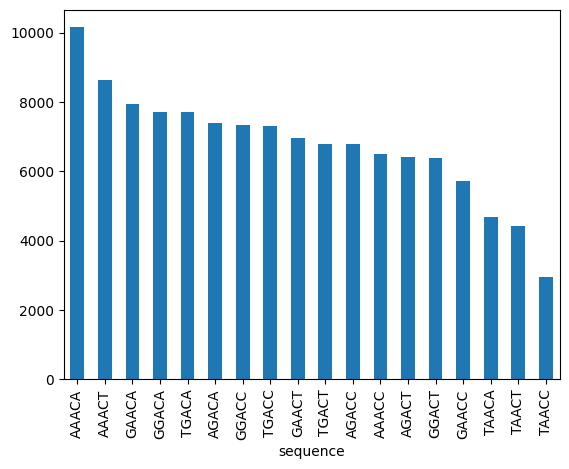

In [59]:
# Plot the distribution of sequence
df['sequence'].value_counts().plot(kind='bar')

3. Inner join the dataset and labels on the transcript id and position

In [60]:
# Inner join df on labels
merged_df = pd.merge(df, labels,
                     left_on  = ['transcript_id', 'position'],
                     right_on = ['transcript_id', 'transcript_position'],
                     how = 'left')

# Drop the duplicate column and reorder the columns
gene_id = merged_df['gene_id']
merged_df = merged_df.drop(columns=['transcript_position', 'gene_id'])
merged_df.insert(0, 'gene_id', gene_id)

merged_df.head(3)

,gene_id,transcript_id,position,sequence,data,one_hot_encoded,combined,label
0,ENSG00000004059,ENST00000000233,244,AGACC,"[0.008264378378378385, 4.223783783783786, 123....","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.008264378378378385, 4.223783783783786, 123....",0
1,ENSG00000004059,ENST00000000233,261,AAACT,"[0.006609244186046515, 3.2164244186046504, 109...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.006609244186046515, 3.2164244186046504, 109...",0
2,ENSG00000004059,ENST00000000233,316,AAACA,"[0.0075699999999999995, 2.94054054054054, 105....","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0075699999999999995, 2.94054054054054, 105....",0


Split the dataset into train and test sets by gene_id

In [61]:
# Train-test split by gene_id
train_genes, test_genes = train_test_split(labels['gene_id'].unique(), test_size=0.3, random_state=42)

train_df = merged_df[merged_df['gene_id'].isin(train_genes)]
test_df  = merged_df[merged_df['gene_id'].isin(test_genes)]

X_train = np.vstack(train_df['combined'].values)
y_train = train_df['label'].values.ravel()

X_test = np.vstack(test_df['combined'].values)
y_test = test_df['label'].values.ravel()

Apply Synthetic Minority Over-sampling Technique (SMOTE)

In [63]:
# Proportion of positive labels
np.mean(labels['label'] == 1)

0.044936719250151844

In [62]:
# Simulate data with label 1 using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

Scale the data

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_resampled)  # Fit and transform on training data
X_test = scaler.transform(X_test)  # Only transform on test data

# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')

## Baseline Model: Logistic Regression

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

Model Training

In [74]:
# Initialize the logistic regression model
log_reg_model = LogisticRegression()

# Define the hyperparameters and their values for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],  # C is the inverse of regularization strength
    'penalty': ['l1', 'l2'], # l1 is Lasso, l2 is Ridge
    'solver': ['liblinear']  # 'liblinear' supports both 'l1' and 'l2' penalties
}

# Use GridSearchCV for hyperparameter tuning
# Use average precision as the scoring metric to handle imbalanced data
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, scoring='average_precision')
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_log_reg_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

c:\Users\hongl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hongl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hongl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hongl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hongl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


c:\Users\hongl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [78]:
# Save the best logistic regression model to a file
joblib.dump(best_log_reg_model, 'best_log_reg_model.pkl')

['best_log_reg_model.pkl']

Model Evaluation

In [83]:
from sklearn.metrics import average_precision_score, precision_recall_curve, auc

Average Precision Score: 0.12589516460529013


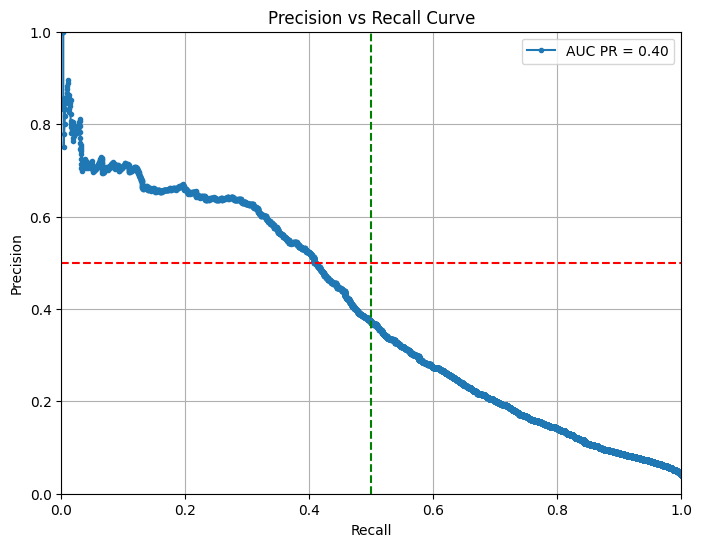

AUC-PR Score: 0.3977515987901381


In [85]:
# Get the class prediction
y_pred = best_log_reg_model.predict(X_test)

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred)
print("Average Precision Score:", average_precision)

# Get the probabilities for the positive class
y_scores = best_log_reg_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate the AUC for the Precision-Recall curve
auc_pr = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'AUC PR = {auc_pr:.2f}')
plt.title('Precision vs Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 precision
plt.axvline(x=0.5, color='g', linestyle='--')  # Reference line for 0.5 recall
plt.legend()
plt.show()

# Print AUC PR score
print("AUC-PR Score:", auc_pr)

## Advanced Model: Some neural network

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [68]:
# Create a sequential model
model = Sequential()

# Input layer (input_shape should match your feature count)
model.add(Dense(150, activation='relu', input_shape=(X_resampled.shape[1],)))  # First hidden layer
model.add(Dropout(0.2))  # Optional: dropout layer for regularization

# Second hidden layer
model.add(Dense(32, activation='relu'))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary output

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Fit the model to the training data
model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_split=0.2)  # Adjust epochs and batch_size as needed

# After fitting, you can save the model if required
# model.save('your_model.h5')

# Print model summary
model.summary()

Epoch 1/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6705 - loss: 0.8225 - val_accuracy: 0.8161 - val_loss: 0.4728
Epoch 2/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7646 - loss: 0.4879 - val_accuracy: 0.5668 - val_loss: 0.7905
Epoch 3/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7706 - loss: 0.4789 - val_accuracy: 0.6112 - val_loss: 0.7641
Epoch 4/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7737 - loss: 0.4744 - val_accuracy: 0.7973 - val_loss: 0.4861
Epoch 5/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7744 - loss: 0.4729 - val_accuracy: 0.4521 - val_loss: 0.8799
Epoch 6/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7779 - loss: 0.4679 - val_accuracy: 0.6377 - val_loss: 0.7059
Epoch 7/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7789 - loss: 0.4656 - val_accuracy: 0.6362 - val_loss: 0.6543
Epoch 8/10
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7810 - loss: 0.4617 - 

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 150)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,197 (106.24 KB)

 Trainable params: 9,065 (35.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,132 (70.83 KB)

In [60]:
# model.save('stupid')

INFO:tensorflow:Assets written to: stupid\assets


1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


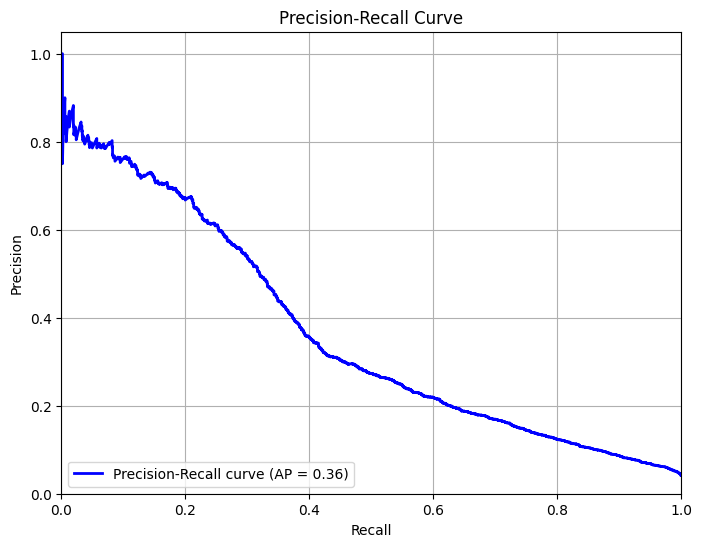

Average Precision Score: 0.36367570450534037


In [69]:

# Make predictions on the test set
predicted_probabilities = model.predict(X_test).flatten()  # Flatten to 1D array

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, predicted_probabilities)

# Calculate average precision score
average_precision = average_precision_score(y_test, predicted_probabilities)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = {:.2f})'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc='lower left')
plt.show()

# Print average precision score
print("Average Precision Score:", average_precision)
